In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 832)
(466039, 1)
validation
(80707, 832)
(80707, 1)
test
(46831, 832)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 57s - loss: 0.0967 - STD: 2.8608e-04 - MAE: 0.2973

 4/47 [=>............................] - ETA: 0s - loss: 0.0435 - STD: 3.4026e-04 - MAE: 0.1586 

 7/47 [===>..........................] - ETA: 0s - loss: 0.0416 - STD: 2.7051e-04 - MAE: 0.1552

11/47 [======>.......................] - ETA: 0s - loss: 0.0369 - STD: 2.8878e-04 - MAE: 0.1394

15/47 [========>.....................] - ETA: 0s - loss: 0.0320 - STD: 3.5096e-04 - MAE: 0.1284

18/47 [==========>...................] - ETA: 0s - loss: 0.0304 - STD: 3.9475e-04 - MAE: 0.1292

21/47 [============>.................] - ETA: 0s - loss: 0.0287 - STD: 4.3371e-04 - MAE: 0.1259

24/47 [==============>...............] - ETA: 0s - loss: 0.0273 - STD: 4.6559e-04 - MAE: 0.1203

25/47 [==============>...............] - ETA: 0s - loss: 0.0271 - STD: 4.7516e-04 - MAE: 0.1186

29/47 [=================>............] - ETA: 0s - loss: 0.0259 - STD: 5.1700e-04 - MAE: 0.1127

32/47 [===================>..........] - ETA: 0s - loss: 0.0251 - STD: 5.5855e-04 - MAE: 0.1096

35/47 [=====================>........] - ETA: 0s - loss: 0.0244 - STD: 6.1116e-04 - MAE: 0.1082

39/47 [=======================>......] - ETA: 0s - loss: 0.0237 - STD: 6.9370e-04 - MAE: 0.1073

41/47 [=========================>....] - ETA: 0s - loss: 0.0234 - STD: 7.3821e-04 - MAE: 0.1066

44/47 [===========================>..] - ETA: 0s - loss: 0.0229 - STD: 8.0898e-04 - MAE: 0.1051

47/47 [==============================] - 3s 44ms/step - loss: 0.0225 - STD: 8.8908e-04 - MAE: 0.1035 - val_loss: 0.0158 - val_STD: 0.0019 - val_MAE: 0.0686


Epoch 2/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0169 - STD: 0.0024 - MAE: 0.0805

 4/47 [=>............................] - ETA: 0s - loss: 0.0169 - STD: 0.0026 - MAE: 0.0829

 7/47 [===>..........................] - ETA: 0s - loss: 0.0167 - STD: 0.0030 - MAE: 0.0851

11/47 [======>.......................] - ETA: 0s - loss: 0.0166 - STD: 0.0035 - MAE: 0.0867

15/47 [========>.....................] - ETA: 0s - loss: 0.0164 - STD: 0.0041 - MAE: 0.0863

18/47 [==========>...................] - ETA: 0s - loss: 0.0163 - STD: 0.0047 - MAE: 0.0853

21/47 [============>.................] - ETA: 0s - loss: 0.0162 - STD: 0.0054 - MAE: 0.0846

24/47 [==============>...............] - ETA: 0s - loss: 0.0160 - STD: 0.0064 - MAE: 0.0842

27/47 [================>.............] - ETA: 0s - loss: 0.0158 - STD: 0.0076 - MAE: 0.0840

30/47 [==================>...........] - ETA: 0s - loss: 0.0156 - STD: 0.0091 - MAE: 0.0834

33/47 [====================>.........] - ETA: 0s - loss: 0.0153 - STD: 0.0109 - MAE: 0.0824

37/47 [======================>.......] - ETA: 0s - loss: 0.0149 - STD: 0.0141 - MAE: 0.0809

40/47 [========================>.....] - ETA: 0s - loss: 0.0145 - STD: 0.0172 - MAE: 0.0797

43/47 [==========================>...] - ETA: 0s - loss: 0.0141 - STD: 0.0206 - MAE: 0.0784

47/47 [==============================] - ETA: 0s - loss: 0.0135 - STD: 0.0255 - MAE: 0.0765

47/47 [==============================] - 1s 22ms/step - loss: 0.0135 - STD: 0.0255 - MAE: 0.0765 - val_loss: 0.0062 - val_STD: 0.0721 - val_MAE: 0.0516


Epoch 3/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0071 - STD: 0.0866 - MAE: 0.0552

 4/47 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0900 - MAE: 0.0534

 7/47 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0917 - MAE: 0.0522

10/47 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0944 - MAE: 0.0512

13/47 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0960 - MAE: 0.0505

16/47 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0982 - MAE: 0.0501

19/47 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0995 - MAE: 0.0494

23/47 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.1009 - MAE: 0.0488

26/47 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.1019 - MAE: 0.0484

29/47 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.1026 - MAE: 0.0480

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.1035 - MAE: 0.0476

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.1044 - MAE: 0.0473

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.1049 - MAE: 0.0470

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.1054 - MAE: 0.0468

47/47 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.1061 - MAE: 0.0465

47/47 [==============================] - 1s 21ms/step - loss: 0.0050 - STD: 0.1061 - MAE: 0.0465 - val_loss: 0.0041 - val_STD: 0.0897 - val_MAE: 0.0432


Epoch 4/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.1087 - MAE: 0.0428

 4/47 [=>............................] - ETA: 0s - loss: 0.0041 - STD: 0.1101 - MAE: 0.0430

 7/47 [===>..........................] - ETA: 0s - loss: 0.0040 - STD: 0.1107 - MAE: 0.0427

11/47 [======>.......................] - ETA: 0s - loss: 0.0039 - STD: 0.1115 - MAE: 0.0425

14/47 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.1120 - MAE: 0.0424

17/47 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.1124 - MAE: 0.0423

20/47 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.1127 - MAE: 0.0421

23/47 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.1130 - MAE: 0.0420

27/47 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.1133 - MAE: 0.0418

30/47 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.1134 - MAE: 0.0417

33/47 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.1136 - MAE: 0.0415

36/47 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.1137 - MAE: 0.0414

39/47 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.1138 - MAE: 0.0412

42/47 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.1140 - MAE: 0.0411

45/47 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1142 - MAE: 0.0410

47/47 [==============================] - 1s 22ms/step - loss: 0.0036 - STD: 0.1142 - MAE: 0.0409 - val_loss: 0.0038 - val_STD: 0.0965 - val_MAE: 0.0408


Epoch 5/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0032 - STD: 0.1126 - MAE: 0.0387

 3/47 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.1138 - MAE: 0.0387

 7/47 [===>..........................] - ETA: 0s - loss: 0.0032 - STD: 0.1150 - MAE: 0.0387

10/47 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.1157 - MAE: 0.0387

14/47 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.1161 - MAE: 0.0386

18/47 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.1165 - MAE: 0.0385

21/47 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.1166 - MAE: 0.0385

24/47 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1168 - MAE: 0.0384

27/47 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0383

31/47 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0383

35/47 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1171 - MAE: 0.0382

39/47 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1172 - MAE: 0.0381

42/47 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0381

45/47 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1173 - MAE: 0.0380

47/47 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.1173 - MAE: 0.0380 - val_loss: 0.0037 - val_STD: 0.1008 - val_MAE: 0.0396


Epoch 6/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.1194 - MAE: 0.0381

 4/47 [=>............................] - ETA: 0s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0371

 7/47 [===>..........................] - ETA: 0s - loss: 0.0030 - STD: 0.1183 - MAE: 0.0372

10/47 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.1178 - MAE: 0.0370

13/47 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.1177 - MAE: 0.0370

16/47 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.1179 - MAE: 0.0369

19/47 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.1180 - MAE: 0.0369

22/47 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.1178 - MAE: 0.0369

26/47 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1181 - MAE: 0.0368

29/47 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1181 - MAE: 0.0368

32/47 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1182 - MAE: 0.0368

36/47 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0368

39/47 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1183 - MAE: 0.0367

42/47 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1184 - MAE: 0.0367

45/47 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1185 - MAE: 0.0366

47/47 [==============================] - 1s 21ms/step - loss: 0.0028 - STD: 0.1186 - MAE: 0.0366 - val_loss: 0.0035 - val_STD: 0.0998 - val_MAE: 0.0384


Epoch 7/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1140 - MAE: 0.0359

 4/47 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.1187 - MAE: 0.0360

 7/47 [===>..........................] - ETA: 0s - loss: 0.0028 - STD: 0.1191 - MAE: 0.0359

10/47 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0358

14/47 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.1187 - MAE: 0.0359

17/47 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0359

20/47 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1188 - MAE: 0.0358

23/47 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0357

27/47 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0357

30/47 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0357

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0357

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0356

40/47 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0356

43/47 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0356

47/47 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0357

47/47 [==============================] - 1s 21ms/step - loss: 0.0027 - STD: 0.1192 - MAE: 0.0357 - val_loss: 0.0041 - val_STD: 0.1075 - val_MAE: 0.0384


Epoch 8/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.1265 - MAE: 0.0372

 4/47 [=>............................] - ETA: 0s - loss: 0.0028 - STD: 0.1209 - MAE: 0.0367

 8/47 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.1196 - MAE: 0.0363

11/47 [======>.......................] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0359

14/47 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0357

18/47 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0355

21/47 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0354

24/47 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0353

28/47 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1193 - MAE: 0.0353

31/47 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1192 - MAE: 0.0352

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0351

37/47 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1194 - MAE: 0.0351

40/47 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1195 - MAE: 0.0350

43/47 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0350

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0350

47/47 [==============================] - 1s 21ms/step - loss: 0.0026 - STD: 0.1198 - MAE: 0.0350 - val_loss: 0.0035 - val_STD: 0.0971 - val_MAE: 0.0400


Epoch 9/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1169 - MAE: 0.0371

 5/47 [==>...........................] - ETA: 0s - loss: 0.0027 - STD: 0.1209 - MAE: 0.0360

 8/47 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.1204 - MAE: 0.0366

11/47 [======>.......................] - ETA: 0s - loss: 0.0028 - STD: 0.1197 - MAE: 0.0373

15/47 [========>.....................] - ETA: 0s - loss: 0.0028 - STD: 0.1200 - MAE: 0.0372

18/47 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1199 - MAE: 0.0370

21/47 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1198 - MAE: 0.0367

24/47 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1201 - MAE: 0.0365

27/47 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1200 - MAE: 0.0363

31/47 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0361

34/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1197 - MAE: 0.0360

37/47 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1196 - MAE: 0.0359

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1197 - MAE: 0.0358

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1198 - MAE: 0.0357

47/47 [==============================] - 1s 21ms/step - loss: 0.0027 - STD: 0.1198 - MAE: 0.0356 - val_loss: 0.0034 - val_STD: 0.0980 - val_MAE: 0.0377


Epoch 10/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1169 - MAE: 0.0353

 4/47 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0345

 7/47 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0344

10/47 [=====>........................] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0345

13/47 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0345

16/47 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0345

19/47 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1203 - MAE: 0.0345

22/47 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0344

25/47 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0343

29/47 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0344

32/47 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0343

35/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0343

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1201 - MAE: 0.0343

43/47 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0343

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1202 - MAE: 0.0343

47/47 [==============================] - 1s 21ms/step - loss: 0.0025 - STD: 0.1203 - MAE: 0.0343 - val_loss: 0.0036 - val_STD: 0.1027 - val_MAE: 0.0361


Epoch 11/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1247 - MAE: 0.0348

 4/47 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

 7/47 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0341

10/47 [=====>........................] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0340

13/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1198 - MAE: 0.0340

16/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0339

20/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0341

23/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0341

26/47 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0341

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0341

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0341

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0341

38/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0341

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0341

46/47 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0341

47/47 [==============================] - 1s 21ms/step - loss: 0.0025 - STD: 0.1205 - MAE: 0.0341 - val_loss: 0.0034 - val_STD: 0.1008 - val_MAE: 0.0359


Epoch 12/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

 4/47 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1194 - MAE: 0.0341

 7/47 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0342

10/47 [=====>........................] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0343

13/47 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

16/47 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.1204 - MAE: 0.0343

19/47 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0342

23/47 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.1205 - MAE: 0.0343

26/47 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0342

29/47 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0343

33/47 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0343

36/47 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1206 - MAE: 0.0343

39/47 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1208 - MAE: 0.0342

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1209 - MAE: 0.0342

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

47/47 [==============================] - 1s 21ms/step - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341 - val_loss: 0.0034 - val_STD: 0.1016 - val_MAE: 0.0357


Epoch 13/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1240 - MAE: 0.0335

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1218 - MAE: 0.0338

 7/47 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0339

10/47 [=====>........................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

14/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

17/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0338

20/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0338

23/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

26/47 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0338

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0338

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

47/47 [==============================] - 1s 21ms/step - loss: 0.0024 - STD: 0.1209 - MAE: 0.0338 - val_loss: 0.0035 - val_STD: 0.1023 - val_MAE: 0.0357


Epoch 14/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1196 - MAE: 0.0335

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

 8/47 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0341

11/47 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

14/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

18/47 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0340

22/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

25/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0340

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0341

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0341

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340

47/47 [==============================] - 1s 21ms/step - loss: 0.0024 - STD: 0.1210 - MAE: 0.0340 - val_loss: 0.0035 - val_STD: 0.1033 - val_MAE: 0.0361


Epoch 15/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1201 - MAE: 0.0338

 7/47 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0337

11/47 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0337

14/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0339

17/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0339

20/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0340

23/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0339

26/47 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0339

30/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0337

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0337

47/47 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338

47/47 [==============================] - 1s 21ms/step - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338 - val_loss: 0.0033 - val_STD: 0.1015 - val_MAE: 0.0353


Epoch 16/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1221 - MAE: 0.0336

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1204 - MAE: 0.0341

 7/47 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

11/47 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0338

15/47 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

18/47 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0338

21/47 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0337

25/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0337

28/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1212 - MAE: 0.0336

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0336

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0336

38/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0336

41/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0336

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0338

47/47 [==============================] - 1s 22ms/step - loss: 0.0024 - STD: 0.1211 - MAE: 0.0338 - val_loss: 0.0033 - val_STD: 0.1013 - val_MAE: 0.0359


Epoch 17/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1229 - MAE: 0.0337

 3/47 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1196 - MAE: 0.0350

 7/47 [===>..........................] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0347

10/47 [=====>........................] - ETA: 0s - loss: 0.0025 - STD: 0.1207 - MAE: 0.0345

13/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0344

16/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0343

19/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0342

22/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0341

26/47 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0340

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0339

32/47 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0338

36/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0337

39/47 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1210 - MAE: 0.0337

42/47 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0337

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1211 - MAE: 0.0336

47/47 [==============================] - 1s 21ms/step - loss: 0.0024 - STD: 0.1210 - MAE: 0.0336 - val_loss: 0.0033 - val_STD: 0.1016 - val_MAE: 0.0353


Epoch 18/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.1229 - MAE: 0.0333

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1221 - MAE: 0.0334

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0333

11/47 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0334

15/47 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0333

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0335

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0336

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0336

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0336

35/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0336

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0337

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0337

45/47 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0337

47/47 [==============================] - 1s 21ms/step - loss: 0.0024 - STD: 0.1213 - MAE: 0.0339 - val_loss: 0.0034 - val_STD: 0.1037 - val_MAE: 0.0355


Epoch 19/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1227 - MAE: 0.0335

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0343

 7/47 [===>..........................] - ETA: 0s - loss: 0.0024 - STD: 0.1200 - MAE: 0.0341

11/47 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0339

14/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1203 - MAE: 0.0338

17/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0337

20/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0336

23/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0336

27/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0335

30/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0335

33/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0334

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0334

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0334

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0333

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0333

47/47 [==============================] - 1s 21ms/step - loss: 0.0023 - STD: 0.1211 - MAE: 0.0333 - val_loss: 0.0033 - val_STD: 0.1032 - val_MAE: 0.0353


Epoch 20/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1239 - MAE: 0.0332

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1232 - MAE: 0.0334

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0334

11/47 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1223 - MAE: 0.0333

14/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0332

18/47 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0332

21/47 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0331

24/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0331

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0331

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0331

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0333

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

47/47 [==============================] - 1s 21ms/step - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332 - val_loss: 0.0032 - val_STD: 0.1001 - val_MAE: 0.0356


Epoch 21/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1212 - MAE: 0.0332

 4/47 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0328

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1209 - MAE: 0.0330

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0330

14/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0335

18/47 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0334

21/47 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0333

24/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0333

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0331

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0331

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0332

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0334

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0335

47/47 [==============================] - 1s 21ms/step - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334 - val_loss: 0.0032 - val_STD: 0.1013 - val_MAE: 0.0348


Epoch 22/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1213 - MAE: 0.0320

 4/47 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1209 - MAE: 0.0326

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0326

 9/47 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0327

12/47 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0327

15/47 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

18/47 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0329

21/47 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0330

24/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0330

27/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0331

30/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0331

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1218 - MAE: 0.0332

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0332

39/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

42/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

45/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0333

47/47 [==============================] - 1s 22ms/step - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332 - val_loss: 0.0032 - val_STD: 0.1000 - val_MAE: 0.0354


Epoch 23/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0337

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0334

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0330

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0328

13/47 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328

16/47 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0329

20/47 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0330

23/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0331

26/47 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0331

30/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0331

33/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0330

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0331

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0332

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332

47/47 [==============================] - 1s 21ms/step - loss: 0.0023 - STD: 0.1216 - MAE: 0.0332 - val_loss: 0.0032 - val_STD: 0.0990 - val_MAE: 0.0366


Epoch 24/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1168 - MAE: 0.0342

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1201 - MAE: 0.0331

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0335

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0333

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0332

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0331

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332

29/47 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0332

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0333

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

40/47 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

43/47 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0334

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0333

47/47 [==============================] - 1s 21ms/step - loss: 0.0023 - STD: 0.1213 - MAE: 0.0333 - val_loss: 0.0031 - val_STD: 0.1008 - val_MAE: 0.0347


Epoch 25/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.1179 - MAE: 0.0325

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1204 - MAE: 0.0321

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1206 - MAE: 0.0323

11/47 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1211 - MAE: 0.0324

14/47 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.1209 - MAE: 0.0324

17/47 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1206 - MAE: 0.0325

21/47 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0326

25/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0326

28/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0329

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0329

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0329

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0328

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328

47/47 [==============================] - 1s 21ms/step - loss: 0.0022 - STD: 0.1216 - MAE: 0.0328 - val_loss: 0.0032 - val_STD: 0.1008 - val_MAE: 0.0346


Epoch 26/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1225 - MAE: 0.0324

 4/47 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1233 - MAE: 0.0325

 8/47 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.1222 - MAE: 0.0325

11/47 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1223 - MAE: 0.0329

14/47 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.1222 - MAE: 0.0327

18/47 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0327

22/47 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0327

26/47 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0327

29/47 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0327

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0330

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0331

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0331

42/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0330

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0331

47/47 [==============================] - 1s 20ms/step - loss: 0.0022 - STD: 0.1218 - MAE: 0.0332 - val_loss: 0.0034 - val_STD: 0.0959 - val_MAE: 0.0395


Epoch 27/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1161 - MAE: 0.0367

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1189 - MAE: 0.0341

 7/47 [===>..........................] - ETA: 0s - loss: 0.0023 - STD: 0.1197 - MAE: 0.0337

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0336

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0338

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0338

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0337

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1205 - MAE: 0.0337

25/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0336

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0335

31/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0334

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0333

37/47 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0332

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0331

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0330

47/47 [==============================] - 1s 21ms/step - loss: 0.0022 - STD: 0.1214 - MAE: 0.0330 - val_loss: 0.0032 - val_STD: 0.1015 - val_MAE: 0.0348


Epoch 28/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1210 - MAE: 0.0322

 5/47 [==>...........................] - ETA: 0s - loss: 0.0021 - STD: 0.1216 - MAE: 0.0322

 9/47 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1216 - MAE: 0.0322

12/47 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1218 - MAE: 0.0322

15/47 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0322

18/47 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0324

21/47 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0324

24/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0325

27/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0326

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0325

34/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0325

37/47 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0325

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0325

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0325

47/47 [==============================] - 1s 21ms/step - loss: 0.0022 - STD: 0.1219 - MAE: 0.0325 - val_loss: 0.0035 - val_STD: 0.1032 - val_MAE: 0.0370


Epoch 29/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1240 - MAE: 0.0334

 3/47 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1222 - MAE: 0.0334

 6/47 [==>...........................] - ETA: 0s - loss: 0.0022 - STD: 0.1223 - MAE: 0.0329

 9/47 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.1220 - MAE: 0.0333

12/47 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0331

15/47 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0332

19/47 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0330

22/47 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0329

25/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0328

29/47 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0327

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0327

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0326

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0327

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0328

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0328

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0327

47/47 [==============================] - 1s 22ms/step - loss: 0.0022 - STD: 0.1219 - MAE: 0.0327 - val_loss: 0.0031 - val_STD: 0.1007 - val_MAE: 0.0346


Epoch 30/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1242 - MAE: 0.0320

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1228 - MAE: 0.0320

 7/47 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0320

11/47 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0325

15/47 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0324

18/47 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0324

21/47 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0323

25/47 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1218 - MAE: 0.0323

28/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0327

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0331

34/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0330

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0329

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0328

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0328

47/47 [==============================] - 1s 21ms/step - loss: 0.0022 - STD: 0.1218 - MAE: 0.0327 - val_loss: 0.0032 - val_STD: 0.1034 - val_MAE: 0.0348


Epoch 31/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1246 - MAE: 0.0322

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1231 - MAE: 0.0323

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1212 - MAE: 0.0333

11/47 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.1226 - MAE: 0.0332

15/47 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0332

18/47 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0331

22/47 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0329

25/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0328

28/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0327

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0326

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1219 - MAE: 0.0325

38/47 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0325

41/47 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0324

44/47 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0324

47/47 [==============================] - 1s 20ms/step - loss: 0.0021 - STD: 0.1220 - MAE: 0.0324 - val_loss: 0.0031 - val_STD: 0.1004 - val_MAE: 0.0352


Epoch 32/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1235 - MAE: 0.0324

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1229 - MAE: 0.0319

 8/47 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0318

11/47 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0317

14/47 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0319

17/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1216 - MAE: 0.0337

20/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1224 - MAE: 0.0340

23/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1220 - MAE: 0.0346

26/47 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1216 - MAE: 0.0350

29/47 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1215 - MAE: 0.0357

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1214 - MAE: 0.0364

35/47 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1213 - MAE: 0.0365

38/47 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1214 - MAE: 0.0366

41/47 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1209 - MAE: 0.0365

44/47 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1208 - MAE: 0.0364

47/47 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1208 - MAE: 0.0363

47/47 [==============================] - 1s 21ms/step - loss: 0.0026 - STD: 0.1208 - MAE: 0.0363 - val_loss: 0.0033 - val_STD: 0.0938 - val_MAE: 0.0393


Epoch 33/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0026 - STD: 0.1145 - MAE: 0.0360

 4/47 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.1196 - MAE: 0.0339

 8/47 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.1190 - MAE: 0.0334

12/47 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1198 - MAE: 0.0331

15/47 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1204 - MAE: 0.0330

18/47 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1206 - MAE: 0.0330

22/47 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1209 - MAE: 0.0328

25/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1209 - MAE: 0.0328

28/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1208 - MAE: 0.0327

32/47 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.1209 - MAE: 0.0326

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0325

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1211 - MAE: 0.0325

42/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1211 - MAE: 0.0324

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1212 - MAE: 0.0324

47/47 [==============================] - 1s 21ms/step - loss: 0.0022 - STD: 0.1212 - MAE: 0.0324 - val_loss: 0.0032 - val_STD: 0.1018 - val_MAE: 0.0349


Epoch 34/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1197 - MAE: 0.0319

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1214 - MAE: 0.0321

 7/47 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0320

10/47 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.1218 - MAE: 0.0319

13/47 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.1218 - MAE: 0.0319

17/47 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1218 - MAE: 0.0318

20/47 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0318

24/47 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0319

27/47 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0319

30/47 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0319

34/47 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0319

37/47 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0320

40/47 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0320

44/47 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0320

47/47 [==============================] - 1s 21ms/step - loss: 0.0021 - STD: 0.1221 - MAE: 0.0321 - val_loss: 0.0032 - val_STD: 0.1017 - val_MAE: 0.0347


Epoch 35/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.1238 - MAE: 0.0324

 4/47 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1230 - MAE: 0.0328

 7/47 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0322

11/47 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0320

15/47 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.1225 - MAE: 0.0320

18/47 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1225 - MAE: 0.0320

21/47 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1227 - MAE: 0.0320

24/47 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1225 - MAE: 0.0320

27/47 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1225 - MAE: 0.0320

30/47 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0320

33/47 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0320

36/47 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0320

39/47 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0319

42/47 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0319

46/47 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0319

47/47 [==============================] - 1s 21ms/step - loss: 0.0021 - STD: 0.1223 - MAE: 0.0319 - val_loss: 0.0032 - val_STD: 0.1021 - val_MAE: 0.0352


Epoch 36/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1240 - MAE: 0.0325

 4/47 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1230 - MAE: 0.0321

 7/47 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.1229 - MAE: 0.0322

10/47 [=====>........................] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0320

13/47 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0319

16/47 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0319

20/47 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0319

23/47 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0319

26/47 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0319

29/47 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0319

32/47 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0319

35/47 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0320

38/47 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1225 - MAE: 0.0320

41/47 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1226 - MAE: 0.0321

44/47 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0321

47/47 [==============================] - 1s 21ms/step - loss: 0.0021 - STD: 0.1224 - MAE: 0.0320 - val_loss: 0.0033 - val_STD: 0.1035 - val_MAE: 0.0356


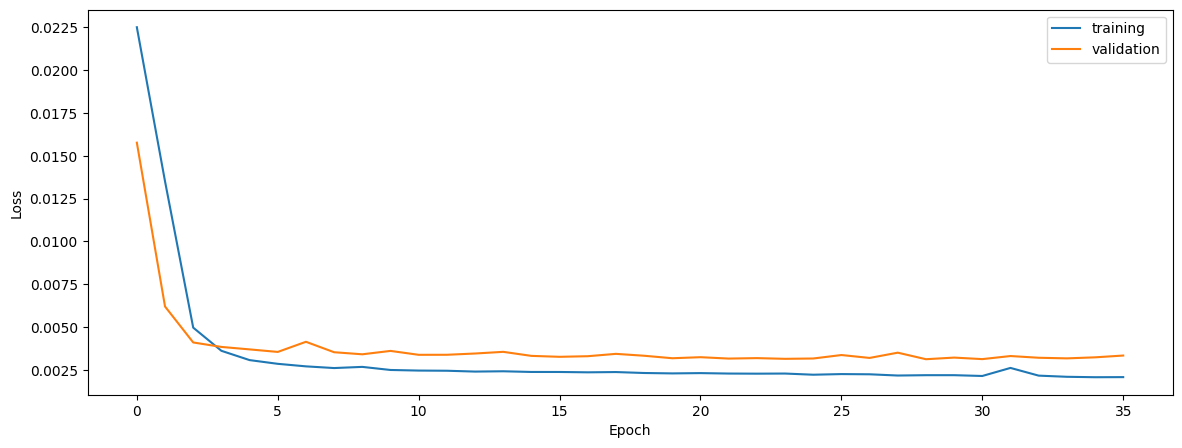

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


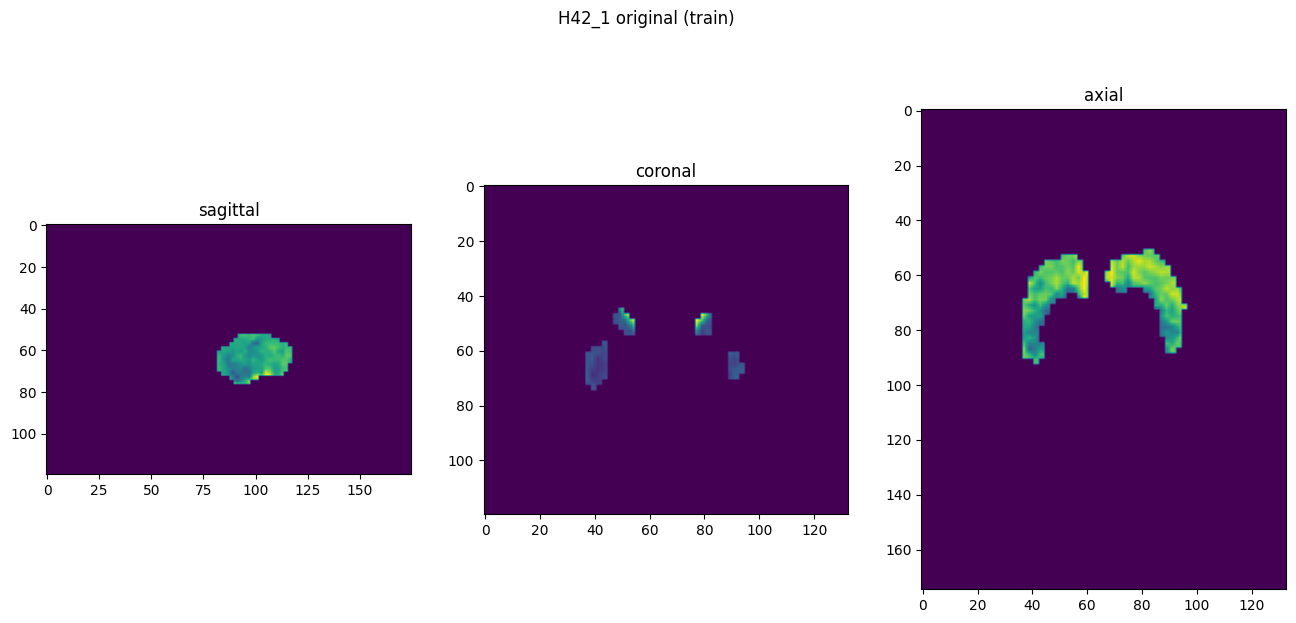

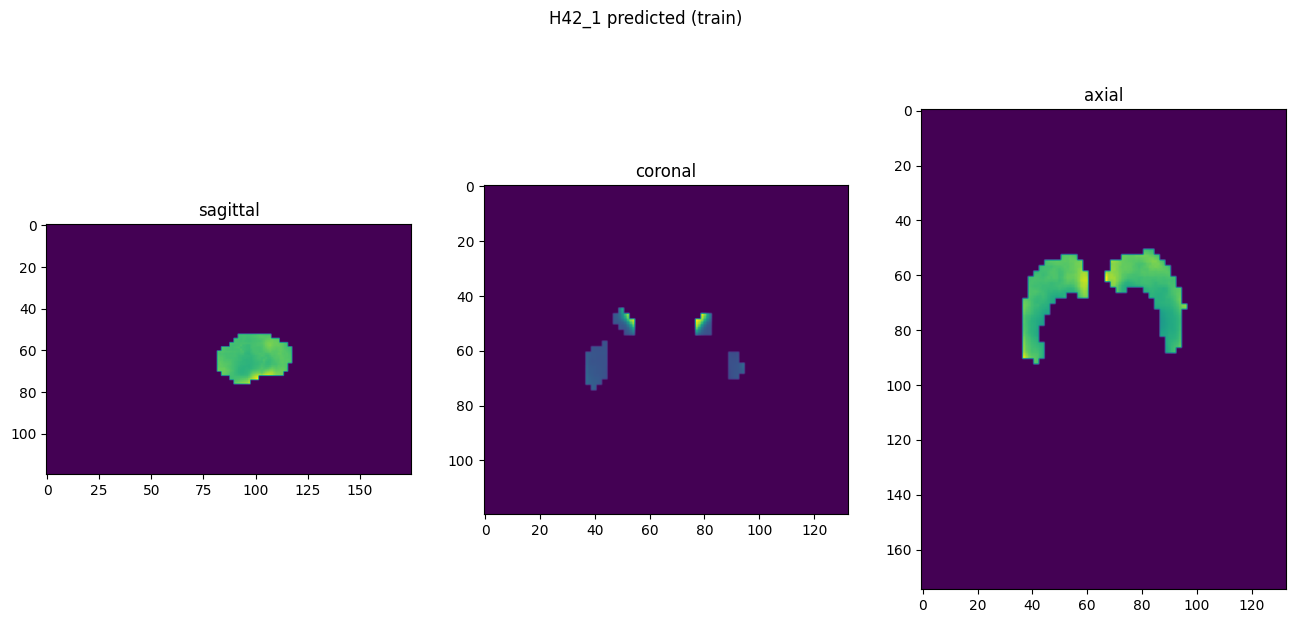

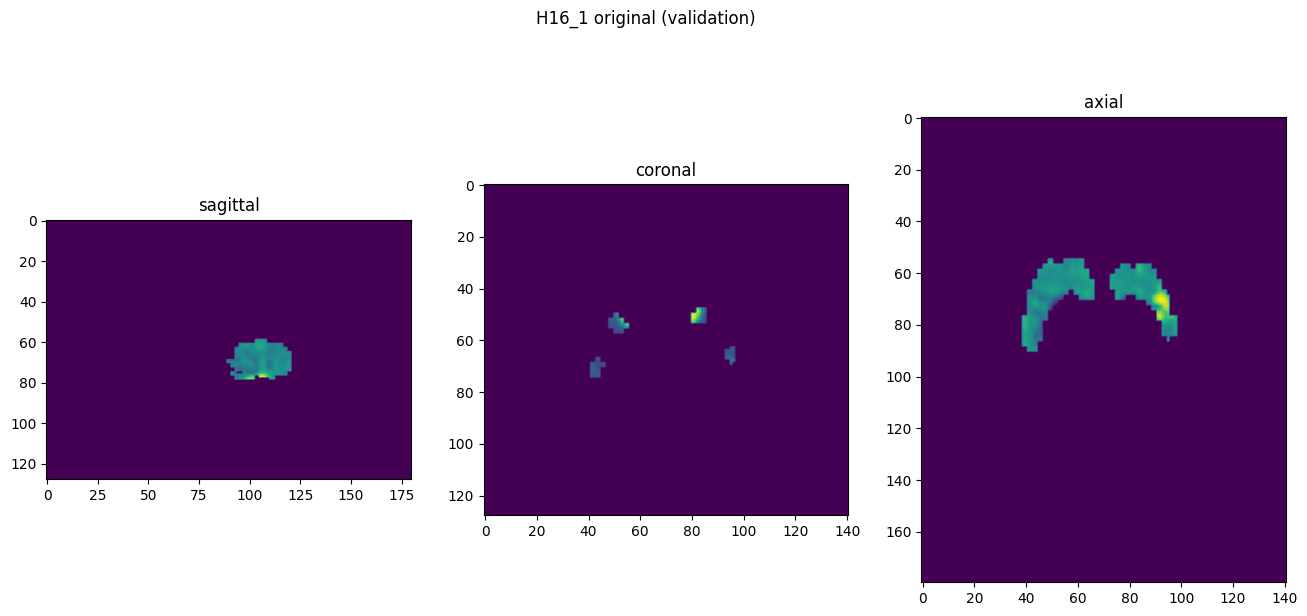

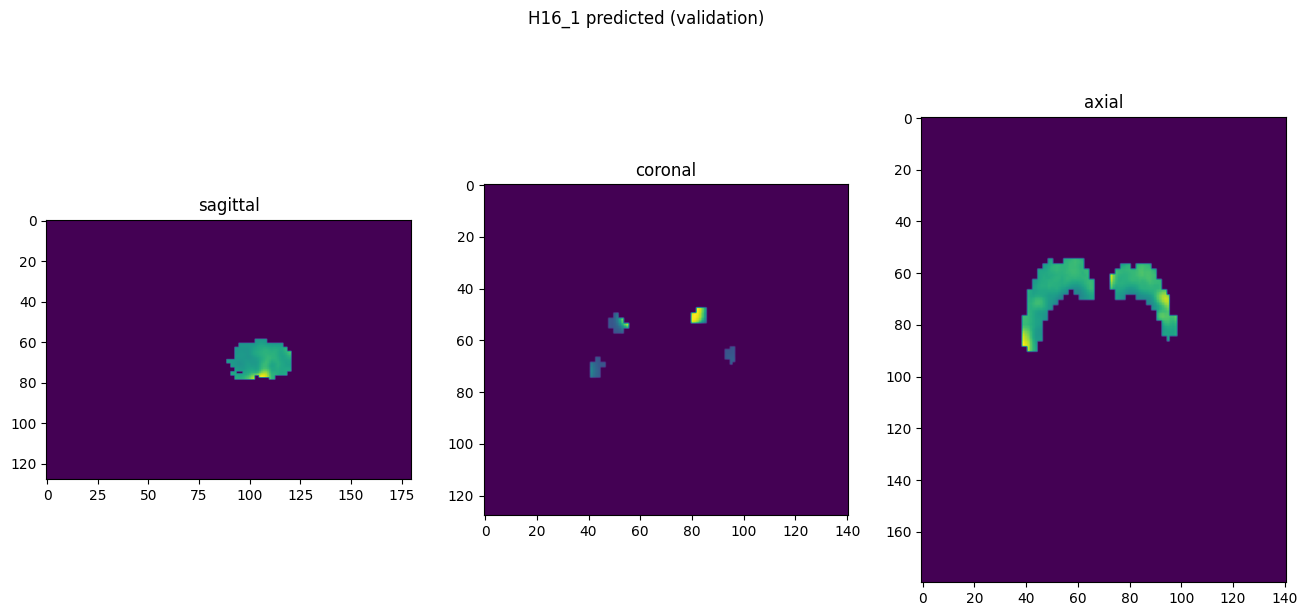

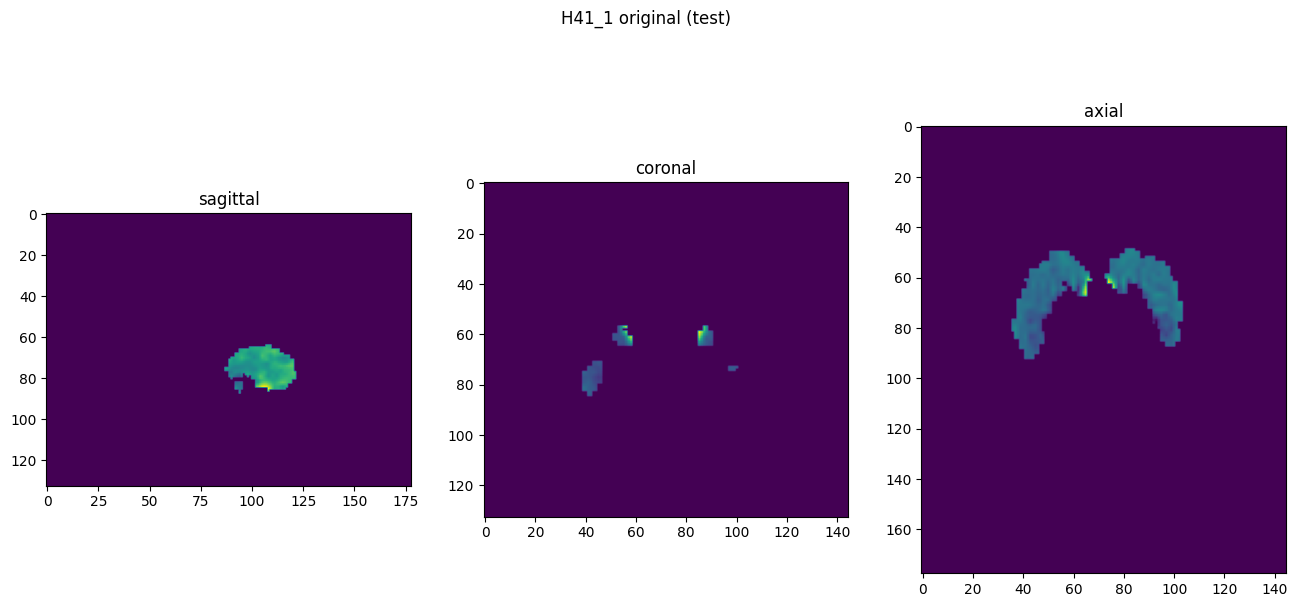

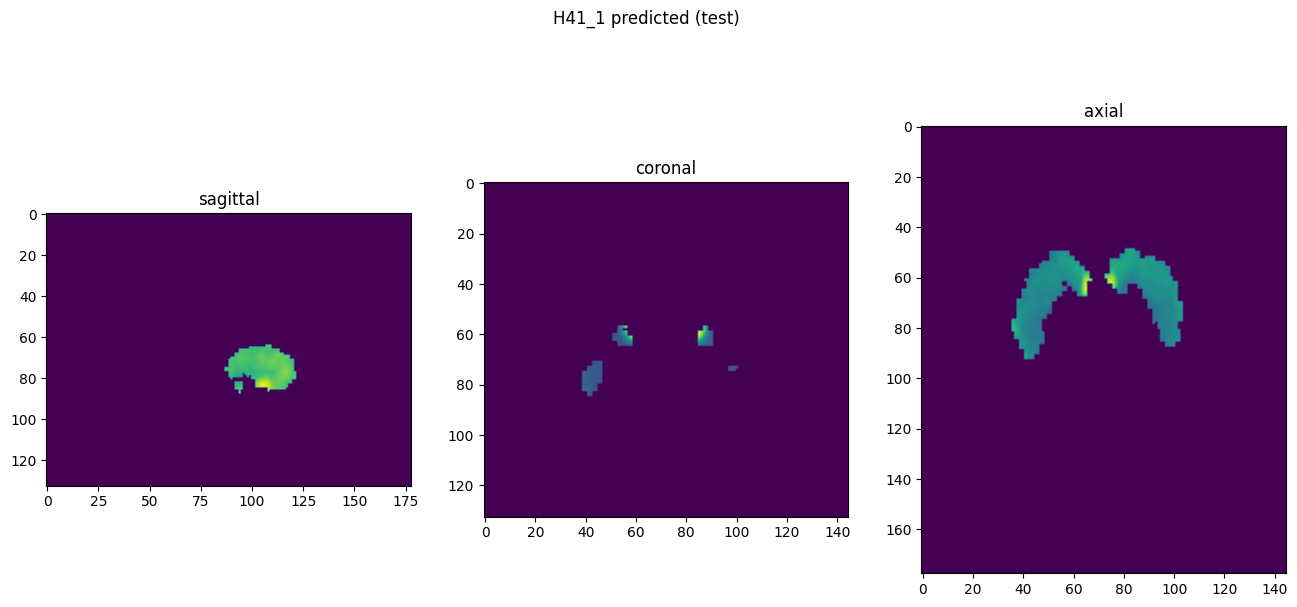

In [10]:
showResults(model, gen, threshold=None, background=False)